In [1]:
import pandas as pd
import itertools
import matplotlib as mpl
from pandas_datareader import data as pd_data
import statsmodels.api as sm
from linearmodels import iv

In [8]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.style.use('seaborn-talk')

if paper:
    presentation_fontsize = 16
else:
    presentation_fontsize = 22
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})

## Import Vol Data

In [9]:
with pd.HDFStore('../results/spy_daily_estimates_2003-2017_1000_1sec.hdf') as volatility_store:
    discrete_vol = volatility_store['discrete_vol_est'].replace(0, np.nan).dropna()
    
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
discrete_vol['prop'] = discrete_vol['jumps'] / discrete_vol['quad']
log_vol = discrete_vol.transform(np.log).dropna()
log_vol.columns = ['log_' + val for val in discrete_vol.columns]

In [10]:
weights = ((discrete_vol.quad * 252)**(-1)).to_frame().rename(columns={'quad':'weights'})

In [11]:
daily_rtn_data = pd.read_csv('../results/spy_daily_rtn_2003-2017_with_overnight.csv', index_col=0,
                         parse_dates=True).rename(columns={'log_price':'daily_rtn'}).daily_rtn
treasury_yield = pd_data.get_data_fred('DGS10', start='1950', end='2018').apply(
    lambda x: np.log(x/(100 * 365) + 1)).rename(columns={'DGS10':'log_yield'})
daily_rtn = 252 * (daily_rtn_data - treasury_yield.T).T.rename(columns={'log_yield':'daily_rtn'}).dropna()

In [12]:
fed_announcement_dates = pd.read_hdf('../results/fomc_times.hdf', 'table')
dates = pd.DataFrame(np.ones((fed_announcement_dates.size,1)), 
                     index=fed_announcement_dates['FOMC_times']).resample('D').last().fillna(0).rename(
    columns={0:'fomc_dates'})

In [13]:
paper = False

In [14]:
har_lags = [1, 2, 5, 25]

## In this section, I make a bar chart to display the FOMC premium.

In [15]:
FOMC = np.ravel([10.8024 , 2.3302 , 1.3281 , 1.9024 , 8.71 , -2.492 , 0.1611 , 1.071195 ])
FOMC_t =  np.ravel([3.3183 , 2.0608 , 0.705589 , 1.1423 , 1.4742 , -0.40266 , 0.0725  , 0.4759])
non_FOMC  = np.ravel([-1.636 , -1.3477 , -0.9284 , -1.2329 , -1.1112 , -0.8870 , -0.8677 , -1.1456 ])
non_FOMC_t = np.ravel([ -2.0775 , -2.701 , -2.2712 , -2.871 , -2.2368 , -1.3642 , -3.768 , -2.4827])


FOMC_se = FOMC / FOMC_t
non_FOMC_se = non_FOMC_t / non_FOMC
xvals = np.arange(-5, 3, 1)

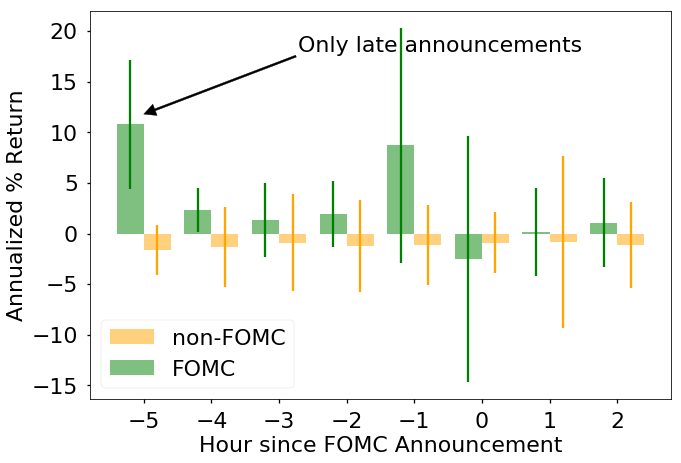

In [20]:
fomc_fig, fomc_ax  = mpl.pyplot.subplots()
fomc_ax.bar(x=xvals+.2, height=non_FOMC, yerr=1.96 * non_FOMC_se, color='orange', alpha=.5, width=.4,
            error_kw={'ecolor':'orange'}, label='non-FOMC')
fomc_ax.bar(x=xvals-.2, height=FOMC, yerr=1.96 * FOMC_se, color='green', alpha=.5, width=.4,
            error_kw={'ecolor':'green'}, label='FOMC')
fomc_ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(xvals))
fomc_ax.legend(loc='lower left')
fomc_ax.annotate('Only late announcements', xy=(-5, 11.8), xytext=(-2.72,18),
                 arrowprops={'width':2, 'color':'black'}, fontsize=presentation_fontsize,
                 xycoords='data',textcoords='data')
fomc_ax.set_ylabel('Annualized % Return')
fomc_ax.set_xlabel('Hour since FOMC Announcement')
fomc_fig.savefig('../doc/figures/fomc_premium_present.pdf', bbox_inches="tight", transparent=True, 
                   pad_inches=0, frameon=False)

## Compare with Jump Proportion

In [22]:
data = pd.concat([dates, discrete_vol, daily_rtn,log_vol, weights], axis=1).dropna()

In [24]:
data.head()

fomc_dates  absolute   diffusion       jumps        quad    prop  \
2003-01-03         0.0    0.0081  7.1296e-05  5.1311e-05  1.2261e-04  0.4185   
2003-01-06         0.0    0.0061  3.3123e-05  3.9098e-05  7.2221e-05  0.5414   
2003-01-07         0.0    0.0087  7.0698e-05  5.9916e-05  1.3061e-04  0.4587   
2003-01-08         0.0    0.0074  3.9652e-05  6.1865e-05  1.0152e-04  0.6094   
2003-01-09         0.0    0.0062  2.2008e-05  5.6997e-05  7.9005e-05  0.7214   

            daily_rtn  log_absolute  log_diffusion  log_jumps  log_quad  \
2003-01-03    -0.1317       -4.8204        -9.5487    -9.8776   -9.0065   
2003-01-06     5.4954       -5.0934       -10.3153   -10.1494   -9.5358   
2003-01-07    -1.5315       -4.7491        -9.5571    -9.7226   -8.9433   
2003-01-08    -3.7850       -4.9081       -10.1354    -9.6905   -9.1953   
2003-01-09     4.8963       -5.0847       -10.7241    -9.7725   -9.4460   

            log_prop  weights  
2003-01-03   -0.8711  32.3658  
2003-01-06   -0.6137  54.9458  
2003-01-07   -0.7793  30.3815  
2003-01-08   -0.4953  39.0895  
2003-01-09   -0.3265  50.2282

In [25]:
data.corr()

fomc_dates  absolute  diffusion   jumps    quad    prop  \
fomc_dates         1.0000    0.0260     0.0079  0.0615  0.0299  0.0475   
absolute           0.0260    1.0000     0.8227  0.8311  0.8808 -0.3211   
diffusion          0.0079    0.8227     1.0000  0.7420  0.9634 -0.2880   
jumps              0.0615    0.8311     0.7420  1.0000  0.8946 -0.0989   
quad               0.0299    0.8808     0.9634  0.8946  1.0000 -0.2315   
prop               0.0475   -0.3211    -0.2880 -0.0989 -0.2315  1.0000   
daily_rtn          0.0536   -0.1637    -0.1144 -0.1315 -0.1289  0.1243   
log_absolute       0.0411    0.8918     0.5407  0.6471  0.6192 -0.3132   
log_diffusion      0.0550    0.8766     0.5467  0.6154  0.6105 -0.4930   
log_jumps          0.0886    0.8441     0.4816  0.6587  0.5845 -0.0600   
log_quad           0.0761    0.8878     0.5363  0.6597  0.6214 -0.2711   
log_prop           0.0411   -0.3592    -0.3427 -0.1279 -0.2796  0.9857   
weights           -0.0696   -0.5269    -0.2163 -0.3115 -0.2688  0.1527   

               daily_rtn  log_absolute  log_diffusion  log_jumps  log_quad  \
fomc_dates        0.0536        0.0411         0.0550     0.0886    0.0761   
absolute         -0.1637        0.8918         0.8766     0.8441    0.8878   
diffusion        -0.1144        0.5407         0.5467     0.4816    0.5363   
jumps            -0.1315        0.6471         0.6154     0.6587    0.6597   
quad             -0.1289        0.6192         0.6105     0.5845    0.6214   
prop              0.1243       -0.3132        -0.4930    -0.0600   -0.2711   
daily_rtn         1.0000       -0.1718        -0.1785    -0.1423   -0.1643   
log_absolute     -0.1718        1.0000         0.9776     0.9637    0.9962   
log_diffusion    -0.1785        0.9776         1.0000     0.8975    0.9696   
log_jumps        -0.1423        0.9637         0.8975     1.0000    0.9764   
log_quad         -0.1643        0.9962         0.9696     0.9764    1.0000   
log_prop          0.1281       -0.3303        -0.5006    -0.0779   -0.2914   
weights           0.1086       -0.7958        -0.7630    -0.7981   -0.7991   

               log_prop  weights  
fomc_dates       0.0411  -0.0696  
absolute        -0.3592  -0.5269  
diffusion       -0.3427  -0.2163  
jumps           -0.1279  -0.3115  
quad            -0.2796  -0.2688  
prop             0.9857   0.1527  
daily_rtn        0.1281   0.1086  
log_absolute    -0.3303  -0.7958  
log_diffusion   -0.5006  -0.7630  
log_jumps       -0.0779  -0.7981  
log_quad        -0.2914  -0.7991  
log_prop         1.0000   0.1538  
weights          0.1538   1.0000

In [26]:
fomc_dates_idx = data.query('fomc_dates == 1').index

In [27]:
data.loc[fomc_dates_idx].mean() - data.mean()

fomc_dates       9.6873e-01
absolute         5.8900e-04
diffusion        6.6803e-06
jumps            3.1224e-05
quad             3.7904e-05
prop             3.0574e-02
daily_rtn        8.5218e-01
log_absolute     1.1952e-01
log_diffusion    3.4613e-01
log_jumps        4.8513e-01
log_quad         4.3428e-01
log_prop         5.0846e-02
weights         -5.3711e+01
dtype: float64

In [28]:
predicted_mean = iv.IVGMM.from_formula('log_quad ~ 1 + log_quad.shift(1)', data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True).predict().loc[fomc_dates_idx].mean()
predicted_mean - data.log_quad.mean()

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


fitted_values   -0.0943
dtype: float64

In [29]:
predicted_tv1_form = """log_quad ~ 1 + """ + " + ".join([f"log_quad.shift({n})"
                                                         for n in har_lags])
predicted_mean = iv.IVGMM.from_formula(predicted_tv1_form, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True).predict()
(predicted_mean - data.log_quad.mean()).mean()

fitted_values   -0.0078
dtype: float64

In [30]:
predicted_tv1_form = """log_quad ~ 1 + """ + " + ".join([f"log_quad.shift({n})"
                                                         for n in [1]])
predicted_mean = iv.IVGMM.from_formula(predicted_tv1_form, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True).predict()
(predicted_mean - data.log_quad.mean()).mean()

fitted_values   -0.0003
dtype: float64

In [31]:
predicted_tv2_form = """log_quad ~ 1 + """ + " + ".join([f"log_quad.shift({n}) + log_prop.shift({n})"
                                                         for n in har_lags])
predicted_mean = iv.IVGMM.from_formula(predicted_tv2_form, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True).predict()
(predicted_mean - data.log_quad.mean()).mean()

fitted_values   -0.0078
dtype: float64

## Predict the Log Jump Proportion

In [32]:
log_prop_formula1 = """log_prop ~ fomc_dates + """ + " + ".join([f"log_prop.shift({n})" for n in har_lags])
iv.IVGMMCUE.from_formula(log_prop_formula1, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_prop   R-squared:                      0.1180
Estimator:                     IV-GMM   Adj. R-squared:                 0.1168
No. Observations:                3653   F-statistic:                    108.26
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:05:36   Distribution:                  chi2(5)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -0.2833     0.0297    -9.5531     0.0000     -0.3415     -0.2252
fomc_dates             0.0538     0.0219     2.4594     0.0139      0.0109      0.0967
log_prop.shift(1)      0.1821     0.0205     8.8883     0.0000      0.1419      0.2222
log_prop.shift(2)      0.1645     0.0231     7.1151     0.0000      0.1192      0.2099
log_prop.shift(5)      0.1167     0.0182     6.4015     0.0000      0.0810      0.1525
log_prop.shift(25)     0.0625     0.0184     3.3900     0.0007      0.0263      0.0986
======================================================================================
IVGMMResults, id: 0x7f2a216f4dd8

In [33]:
log_prop_formula2 = """log_prop ~ """ + " + ".join([f"log_prop.shift({n})" for n in har_lags])
iv.IVGMMCUE.from_formula(log_prop_formula2, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_prop   R-squared:                      0.1162
Estimator:                     IV-GMM   Adj. R-squared:                 0.1153
No. Observations:                3653   F-statistic:                    110.03
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:05:38   Distribution:                  chi2(4)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -0.2813     0.0297    -9.4825     0.0000     -0.3394     -0.2232
log_prop.shift(1)      0.1824     0.0204     8.9485     0.0000      0.1425      0.2224
log_prop.shift(2)      0.1643     0.0230     7.1381     0.0000      0.1192      0.2094
log_prop.shift(5)      0.1169     0.0184     6.3652     0.0000      0.0809      0.1528
log_prop.shift(25)     0.0629     0.0185     3.3928     0.0007      0.0266      0.0992
======================================================================================
IVGMMResults, id: 0x7f2a215f2550

In [34]:
log_prop_formula3 = ("log_prop ~ " + "".join([f" + log_prop.shift({n})" for n in har_lags]) + 
                    "".join([f" +  log_quad.shift({n})" for n in har_lags]))
iv.IVGMMCUE.from_formula(log_prop_formula3, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_prop   R-squared:                      0.1481
Estimator:                     IV-GMM   Adj. R-squared:                 0.1463
No. Observations:                3653   F-statistic:                    248.07
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:05:44   Distribution:                  chi2(8)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -0.6147     0.0733    -8.3888     0.0000     -0.7583     -0.4710
log_prop.shift(1)      0.1402     0.0167     8.3811     0.0000      0.1074      0.1730
log_prop.shift(2)      0.1251     0.0182     6.8569     0.0000      0.0893      0.1608
log_prop.shift(5)      0.0979     0.0178     5.5134     0.0000      0.0631      0.1327
log_prop.shift(25)     0.0695     0.0170     4.0743     0.0000      0.0360      0.1029
log_quad.shift(1)     -0.0553     0.0080    -6.8895     0.0000     -0.0710     -0.0396
log_quad.shift(2)     -0.0019     0.0076    -0.2473     0.8047     -0.0168      0.0130
log_quad.shift(5)      0.0116     0.0061     1.9099     0.0562     -0.0003      0.0235
log_quad.shift(25)     0.0180     0.0057     3.1352     0.0017      0.0067      0.0292
======================================================================================
IVGMMResults, id: 0x7f2a216449e8

In [35]:
log_prop_formula3 = ("log_prop ~ fomc_dates + " + "".join([f" + log_prop.shift({n})" for n in har_lags]) + 
                    "".join([f" +  log_quad.shift({n})" for n in har_lags]))
iv.IVGMM.from_formula(log_prop_formula3, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_prop   R-squared:                      0.1496
Estimator:                     IV-GMM   Adj. R-squared:                 0.1475
No. Observations:                3653   F-statistic:                    244.41
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:05:45   Distribution:                  chi2(9)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -0.6158     0.0741    -8.3144     0.0000     -0.7609     -0.4706
fomc_dates             0.0487     0.0216     2.2519     0.0243      0.0063      0.0911
log_prop.shift(1)      0.1400     0.0167     8.3732     0.0000      0.1073      0.1728
log_prop.shift(2)      0.1253     0.0183     6.8433     0.0000      0.0894      0.1612
log_prop.shift(5)      0.0976     0.0176     5.5311     0.0000      0.0630      0.1321
log_prop.shift(25)     0.0693     0.0170     4.0735     0.0000      0.0359      0.1026
log_quad.shift(1)     -0.0545     0.0080    -6.7939     0.0000     -0.0703     -0.0388
log_quad.shift(2)     -0.0023     0.0076    -0.3014     0.7631     -0.0172      0.0126
log_quad.shift(5)      0.0111     0.0060     1.8337     0.0667     -0.0008      0.0229
log_quad.shift(25)     0.0182     0.0057     3.1837     0.0015      0.0070      0.0294
======================================================================================
IVGMMResults, id: 0x7f2a21725198

In [36]:
log_prop_formula4 = ("log_prop ~ fomc_dates " + "".join([f" + log_prop.shift({n})" for n in har_lags]) + 
                    "".join([f" +  log_quad.shift({n})" for n in har_lags]) + 
                     " + log_prop.shift(1):log_quad.shift(1)")
iv.IVGMMCUE.from_formula(log_prop_formula4, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_prop   R-squared:                      0.1564
Estimator:                     IV-GMM   Adj. R-squared:                 0.1541
No. Observations:                3653   F-statistic:                    515.21
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:05:51   Distribution:                 chi2(10)
Cov. Estimator:                kernel                                         
                                                                              
                                          Parameter Estimates                                          
=======================================================================================================
                                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------------------
Intercept                              -0.2316     0.0986    -2.3496     0.0188     -0.4247     -0.0384
fomc_dates                              0.0494     0.0220     2.2443     0.0248      0.0063      0.0925
log_prop.shift(1)                       0.7294     0.1034     7.0520     0.0000      0.5267      0.9322
log_prop.shift(2)                       0.1152     0.0177     6.5083     0.0000      0.0805      0.1499
log_prop.shift(5)                       0.0960     0.0176     5.4451     0.0000      0.0614      0.1305
log_prop.shift(25)                      0.0648     0.0166     3.8968     0.0001      0.0322      0.0973
log_quad.shift(1)                      -0.0153     0.0107    -1.4234     0.1546     -0.0363      0.0057
log_quad.shift(2)                      -0.0009     0.0077    -0.1188     0.9054     -0.0161      0.0142
log_quad.shift(5)                       0.0108     0.0060     1.7902     0.0734     -0.0010      0.0226
log_quad.shift(25)                      0.0178     0.0052     3.3912     0.0007      0.0075      0.0281
log_prop.shift(1):log_quad.shift(1)     0.0605     0.0106     5.7344     0.0000      0.0398      0.0812
=======================================================================================================
IVGMMResults, id: 0x7f2a21745be0

In [37]:
log_prop_formula5 = "log_prop ~ log_prop.shift(1)" 
iv.IVGMM.from_formula(log_prop_formula5, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_prop   R-squared:                      0.0661
Estimator:                     IV-GMM   Adj. R-squared:                 0.0658
No. Observations:                3677   F-statistic:                    62.152
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:05:52   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -0.4420     0.0171    -25.836     0.0000     -0.4756     -0.4085
log_prop.shift(1)     0.2570     0.0326     7.8837     0.0000      0.1931      0.3209
=====================================================================================
IVGMMResults, id: 0x7f2a2170b390

## Predict Log Total Volatilty 

In [38]:
total_vol_formula0 = """log_quad ~ log_quad.shift(1)"""
iv.IVGMM.from_formula(total_vol_formula0, weights=data.weights, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_quad   R-squared:                      0.6628
Estimator:                     IV-GMM   Adj. R-squared:                 0.6627
No. Observations:                3677   F-statistic:                    1986.4
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:05:52   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -2.0955     0.1931    -10.853     0.0000     -2.4739     -1.7171
log_quad.shift(1)     0.8164     0.0183     44.569     0.0000      0.7805      0.8523
=====================================================================================
IVGMMResults, id: 0x7f2a21766278

In [39]:
total_vol_formula1 = """log_quad ~ fomc_dates + """ + " + ".join([f"log_quad.shift({n})" for n in har_lags])
iv.IVGMMCUE.from_formula(total_vol_formula1, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_quad   R-squared:                      0.7998
Estimator:                     IV-GMM   Adj. R-squared:                 0.7995
No. Observations:                3653   F-statistic:                    9145.0
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:05:55   Distribution:                  chi2(5)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -0.5723     0.1065    -5.3728     0.0000     -0.7811     -0.3636
fomc_dates             0.5170     0.0468     11.054     0.0000      0.4253      0.6086
log_quad.shift(1)      0.6161     0.0217     28.420     0.0000      0.5736      0.6586
log_quad.shift(2)      0.1637     0.0182     9.0013     0.0000      0.1281      0.1994
log_quad.shift(5)      0.1235     0.0147     8.3810     0.0000      0.0946      0.1524
log_quad.shift(25)     0.0415     0.0097     4.2735     0.0000      0.0225      0.0606
======================================================================================
IVGMMResults, id: 0x7f2a2176f400

In [40]:
total_vol_formula2 = """log_quad ~  """ + " + ".join([f"log_quad.shift({n})" for n in har_lags])
iv.IVGMMCUE.from_formula(total_vol_formula2, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_quad   R-squared:                      0.7921
Estimator:                     IV-GMM   Adj. R-squared:                 0.7919
No. Observations:                3653   F-statistic:                    7712.2
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:05:59   Distribution:                  chi2(4)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -0.5664     0.1146    -4.9423     0.0000     -0.7910     -0.3418
log_quad.shift(1)      0.6078     0.0230     26.421     0.0000      0.5627      0.6529
log_quad.shift(2)      0.1681     0.0188     8.9632     0.0000      0.1314      0.2049
log_quad.shift(5)      0.1288     0.0151     8.5516     0.0000      0.0993      0.1583
log_quad.shift(25)     0.0391     0.0096     4.0685     0.0000      0.0203      0.0580
======================================================================================
IVGMMResults, id: 0x7f2a2176f6d8

In [41]:
total_vol_formula3 = ("log_quad ~ " + "".join([f" + log_prop.shift({n})" for n in har_lags]) + 
                    "".join([f" +  log_quad.shift({n})" for n in har_lags]))
iv.IVGMMCUE.from_formula(total_vol_formula3, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_quad   R-squared:                      0.7932
Estimator:                     IV-GMM   Adj. R-squared:                 0.7927
No. Observations:                3653   F-statistic:                    9517.4
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:06   Distribution:                  chi2(8)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -0.5904     0.1184    -4.9855     0.0000     -0.8225     -0.3583
log_prop.shift(1)     -0.1504     0.0433    -3.4711     0.0005     -0.2353     -0.0655
log_prop.shift(2)      0.0041     0.0371     0.1104     0.9121     -0.0687      0.0769
log_prop.shift(5)      0.0673     0.0375     1.7924     0.0731     -0.0063      0.1408
log_prop.shift(25)     0.0567     0.0344     1.6479     0.0994     -0.0107      0.1242
log_quad.shift(1)      0.6006     0.0215     27.946     0.0000      0.5584      0.6427
log_quad.shift(2)      0.1638     0.0186     8.7991     0.0000      0.1273      0.2003
log_quad.shift(5)      0.1332     0.0149     8.9198     0.0000      0.1039      0.1624
log_quad.shift(25)     0.0452     0.0103     4.4037     0.0000      0.0251      0.0653
======================================================================================
IVGMMResults, id: 0x7f2a2bb56748

In [42]:
total_vol_formula4 = ("log_quad ~ fomc_dates " + "".join([f" + log_prop.shift({n})" for n in har_lags]) + 
                    "".join([f" +  log_quad.shift({n})" for n in har_lags]))
                     
iv.IVGMMCUE.from_formula(total_vol_formula4, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_quad   R-squared:                      0.8009
Estimator:                     IV-GMM   Adj. R-squared:                 0.8004
No. Observations:                3653   F-statistic:                 1.076e+04
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:13   Distribution:                  chi2(9)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept             -0.6023     0.1135    -5.3078     0.0000     -0.8247     -0.3799
fomc_dates             0.5169     0.0463     11.156     0.0000      0.4261      0.6077
log_prop.shift(1)     -0.1524     0.0423    -3.6048     0.0003     -0.2352     -0.0695
log_prop.shift(2)      0.0069     0.0366     0.1899     0.8494     -0.0647      0.0786
log_prop.shift(5)      0.0636     0.0371     1.7125     0.0868     -0.0092      0.1363
log_prop.shift(25)     0.0546     0.0347     1.5745     0.1154     -0.0134      0.1225
log_quad.shift(1)      0.6089     0.0205     29.670     0.0000      0.5687      0.6492
log_quad.shift(2)      0.1594     0.0180     8.8654     0.0000      0.1242      0.1947
log_quad.shift(5)      0.1277     0.0145     8.7840     0.0000      0.0992      0.1561
log_quad.shift(25)     0.0475     0.0105     4.5178     0.0000      0.0269      0.0681
======================================================================================
IVGMMResults, id: 0x7f2a2bb56128

In [43]:
total_vol_formula5 = "log_quad ~ fomc_dates + log_quad.shift(1) + log_prop.shift(1)"
                     
iv.IVGMM.from_formula(total_vol_formula5, data=data.dropna()).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               log_quad   R-squared:                      0.7812
Estimator:                     IV-GMM   Adj. R-squared:                 0.7810
No. Observations:                3677   F-statistic:                    4633.0
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:14   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -1.3926     0.1458    -9.5541     0.0000     -1.6783     -1.1070
fomc_dates            0.5463     0.0520     10.500     0.0000      0.4444      0.6483
log_quad.shift(1)     0.8714     0.0135     64.759     0.0000      0.8450      0.8978
log_prop.shift(1)    -0.1406     0.0454    -3.0985     0.0019     -0.2295     -0.0516
=====================================================================================
IVGMMResults, id: 0x7f2a2bb56470

## Jump Premia Analysis

In [44]:
premia_formula1 = "daily_rtn ~  [1 + log_quad ~ 1 +" + "".join([f" + log_quad.shift({n})" for n in har_lags]) + "]"
premia1 = iv.IVGMMCUE.from_formula(premia_formula1, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia1

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.0491
Estimator:                     IV-GMM   Adj. R-squared:                -0.0494
No. Observations:                3653   F-statistic:                    37.643
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:15   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.0884     0.4482     6.8901     0.0000      2.2099      3.9669
log_quad       0.2542     0.0414     6.1354     0.0000      0.1730      0.3353
==============================================================================

Endogenous: Intercept, log_quad
Instruments: Intercept, log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 15
IVGMMResults, id: 0x7f2a2baaafd0

In [45]:
premia_formula2 = "daily_rtn ~  [1 + log_prop ~ 1 +" + "".join([f" + log_prop.shift({n})" for n in har_lags]) + "]"
premia2 = iv.IVGMMCUE.from_formula(premia_formula2, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia2

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.3595
Estimator:                     IV-GMM   Adj. R-squared:                -0.3599
No. Observations:                3653   F-statistic:                    21.939
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:16   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -2.0828     0.5130    -4.0598     0.0000     -3.0883     -1.0773
log_prop      -4.3274     0.9239    -4.6839     0.0000     -6.1381     -2.5166
==============================================================================

Endogenous: Intercept, log_prop
Instruments: Intercept, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 18
IVGMMResults, id: 0x7f2a2171c1d0

In [46]:
premia_formula3 = ("daily_rtn ~  [1 + log_prop ~ 1 + fomc_dates +" 
                   + "".join([f" + log_prop.shift({n})" for n in har_lags])
                   + "".join([f" + log_quad.shift({n})" for n in har_lags]) + "]")
premia3 = iv.IVGMMCUE.from_formula(premia_formula3, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia3

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.5394
Estimator:                     IV-GMM   Adj. R-squared:                -0.5398
No. Observations:                3653   F-statistic:                    36.580
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:18   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -2.6722     0.5000    -5.3444     0.0000     -3.6522     -1.6922
log_prop      -5.4167     0.8956    -6.0481     0.0000     -7.1721     -3.6614
==============================================================================

Endogenous: Intercept, log_prop
Instruments: Intercept, fomc_dates, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25), log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 23
IVGMMResults, id: 0x7f2a1b6c0358

In [47]:
premia_formula4 = ("daily_rtn ~  [1 + log_quad ~ 1 + fomc_dates +" 
                   + "".join([f" + log_prop.shift({n})" for n in har_lags])
                   + "".join([f" + log_quad.shift({n})" for n in har_lags]) + "]")
premia4 = iv.IVGMMCUE.from_formula(premia_formula4, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia4

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.0518
Estimator:                     IV-GMM   Adj. R-squared:                -0.0521
No. Observations:                3653   F-statistic:                    38.252
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:20   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.1764     0.4594     6.9138     0.0000      2.2759      4.0769
log_quad       0.2636     0.0426     6.1848     0.0000      0.1800      0.3471
==============================================================================

Endogenous: Intercept, log_quad
Instruments: Intercept, fomc_dates, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25), log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 19
IVGMMResults, id: 0x7f2a1ba14fd0

In [48]:
premia_formula5 = ("daily_rtn ~  [1 + fomc_dates ~ 1 + fomc_dates]")
premia5 = iv.IVGMMCUE.from_formula(premia_formula5, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia5

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                      0.0005
Estimator:                     IV-GMM   Adj. R-squared:                 0.0002
No. Observations:                3678   F-statistic:                    2.0866
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.1486
Time:                        11:06:20   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.3385     0.0235     14.434     0.0000      0.2926      0.3845
fomc_dates     0.2592     0.1795     1.4445     0.1486     -0.0925      0.6110
==============================================================================

Endogenous: Intercept, fomc_dates
Instruments: Intercept, fomc_dates
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 31
IVGMMResults, id: 0x7f2a1b8877f0

In [49]:
premia_formula5 = ("daily_rtn ~  [1 + log_quad + log_prop ~ 1 + fomc_dates +" 
                   + "".join([f" + log_prop.shift({n})" for n in har_lags])
                   + "".join([f" + log_quad.shift({n})" for n in har_lags]) + "]")
premia5 = iv.IVGMMCUE.from_formula(premia_formula5, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia5

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.3675
Estimator:                     IV-GMM   Adj. R-squared:                -0.3682
No. Observations:                3653   F-statistic:                    53.245
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:24   Distribution:                  chi2(2)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.4561     0.8647    -0.5274     0.5979     -2.1508      1.2387
log_quad       0.1425     0.0507     2.8108     0.0049      0.0431      0.2418
log_prop      -4.1834     0.8545    -4.8955     0.0000     -5.8583     -2.5086
==============================================================================

Endogenous: Intercept, log_quad, log_prop
Instruments: Intercept, fomc_dates, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25), log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 16
IVGMMResults, id: 0x7f2a1b21ee80

In [50]:
premia_formula6 = ("daily_rtn ~  [1 + log_quad + log_prop ~ 1 + fomc_dates +" 
                   + "".join([f" + log_prop.shift({n})" for n in har_lags])
                   + "".join([f" + log_quad.shift({n})" for n in har_lags]) 
                   + " + log_prop.shift(1):log_quad.shift(1)]")
premia6 = iv.IVGMMCUE.from_formula(premia_formula6, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia6

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.3679
Estimator:                     IV-GMM   Adj. R-squared:                -0.3687
No. Observations:                3653   F-statistic:                    53.006
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:27   Distribution:                  chi2(2)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.4589     0.8509    -0.5393     0.5897     -2.1267      1.2089
log_quad       0.1424     0.0503     2.8312     0.0046      0.0438      0.2409
log_prop      -4.1868     0.8429    -4.9669     0.0000     -5.8389     -2.5347
==============================================================================

Endogenous: Intercept, log_quad, log_prop
Instruments: Intercept, fomc_dates, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25), log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25), log_prop.shift(1):log_quad.shift(1)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 17
IVGMMResults, id: 0x7f2a1aea2550

In [51]:
premia_formula8 = ("daily_rtn ~  [1 + log_quad + log_prop + fomc_dates ~ 1 + fomc_dates +" 
                   + "".join([f" + log_prop.shift({n})" for n in har_lags])
                   + "".join([f" + log_quad.shift({n})" for n in har_lags]) 
                   + " + log_prop.shift(1):log_quad.shift(1)]")
premia8 = iv.IVGMMCUE.from_formula(premia_formula8, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia8

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.3764
Estimator:                     IV-GMM   Adj. R-squared:                -0.3775
No. Observations:                3653   F-statistic:                    53.459
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:29   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.5965     0.8784    -0.6790     0.4971     -2.3180      1.1251
log_quad       0.1342     0.0515     2.6058     0.0092      0.0333      0.2351
log_prop      -4.2611     0.8619    -4.9438     0.0000     -5.9504     -2.5718
fomc_dates     0.2713     0.2088     1.2994     0.1938     -0.1379      0.6806
==============================================================================

Endogenous: Intercept, log_quad, log_prop, fomc_dates
Instruments: Intercept, fomc_dates, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25), log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25), log_prop.shift(1):log_quad.shift(1)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 17
IVGMMResults, id: 0x7f2a1acb8550

### Now use only part of the data

In [52]:
premia_formula9 = ("daily_rtn ~  [1 + log_quad + log_prop + fomc_dates ~ 1 + fomc_dates +" 
                   + "".join([f" + log_prop.shift({n})" for n in har_lags])
                   + "".join([f" + log_quad.shift({n})" for n in har_lags]) 
                   + " + log_prop.shift(1):log_quad.shift(1)]")
data9 = data.copy()[:'2007']
premia9 = iv.IVGMMCUE.from_formula(premia_formula9, weights=data9.weights, data=data9).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia9

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -3.7305
Estimator:                     IV-GMM   Adj. R-squared:                -3.7421
No. Observations:                1223   F-statistic:                    11.516
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0092
Time:                        11:06:35   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -13.992     8.3942    -1.6668     0.0955     -30.444      2.4606
log_quad      -0.4813     0.4779    -1.0070     0.3139     -1.4180      0.4554
log_prop      -17.505     7.0165    -2.4948     0.0126     -31.257     -3.7530
fomc_dates     1.1396     0.8623     1.3216     0.1863     -0.5505      2.8296
==============================================================================

Endogenous: Intercept, log_quad, log_prop, fomc_dates
Instruments: Intercept, fomc_dates, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25), log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25), log_prop.shift(1):log_quad.shift(1)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 16
IVGMMResults, id: 0x7f2a1af6b128

In [53]:
premia_formula10 = ("daily_rtn ~  [1 + log_quad + log_prop + fomc_dates ~ 1 + fomc_dates +" 
                   + "".join([f" + log_prop.shift({n})" for n in har_lags])
                   + "".join([f" + log_quad.shift({n})" for n in har_lags]) 
                   + " + log_prop.shift(1):log_quad.shift(1)]")
data10 = data.copy()['2008':'2012']
premia10 = iv.IVGMMCUE.from_formula(premia_formula10, weights=data10.weights, data=data10).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia10

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.0623
Estimator:                     IV-GMM   Adj. R-squared:                -0.0649
No. Observations:                1224   F-statistic:                    11.491
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0093
Time:                        11:06:38   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.3008     1.7336    -0.1735     0.8623     -3.6985      3.0969
log_quad       0.0434     0.1147     0.3781     0.7053     -0.1814      0.2681
log_prop      -2.0452     1.1856    -1.7251     0.0845     -4.3690      0.2785
fomc_dates     0.7980     0.4439     1.7977     0.0722     -0.0720      1.6681
==============================================================================

Endogenous: Intercept, log_quad, log_prop, fomc_dates
Instruments: Intercept, fomc_dates, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25), log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25), log_prop.shift(1):log_quad.shift(1)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 18
IVGMMResults, id: 0x7f2a1ad6b828

In [54]:
premia_formula11 = ("daily_rtn ~  [1 + log_quad + log_prop + fomc_dates ~ 1 + fomc_dates +" 
                   + "".join([f" + log_prop.shift({n})" for n in har_lags])
                   + "".join([f" + log_quad.shift({n})" for n in har_lags]) 
                   + " + log_prop.shift(1):log_quad.shift(1)]")
data11 = data.copy()['2013':]
premia11 = iv.IVGMMCUE.from_formula(premia_formula11, weights=data11.weights, data=data11).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia11

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.8398
Estimator:                     IV-GMM   Adj. R-squared:                -0.8446
No. Observations:                1156   F-statistic:                    30.477
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:39   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.4142     2.1965     0.1886     0.8504     -3.8910      4.7193
log_quad       0.2593     0.1333     1.9449     0.0518     -0.0020      0.5206
log_prop      -4.9406     1.6558    -2.9838     0.0028     -8.1859     -1.6953
fomc_dates    -0.1433     0.2957    -0.4846     0.6280     -0.7229      0.4363
==============================================================================

Endogenous: Intercept, log_quad, log_prop, fomc_dates
Instruments: Intercept, fomc_dates, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25), log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25), log_prop.shift(1):log_quad.shift(1)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 1
IVGMMResults, id: 0x7f2a1ae49eb8

In [55]:
premia_formula12 = ("daily_rtn ~  [1 + log_quad + log_prop + fomc_dates ~ 1 + fomc_dates +" 
                   + "".join([f" + log_prop.shift({n})" for n in har_lags])
                   + "".join([f" + log_quad.shift({n})" for n in har_lags]) 
                   + " + log_prop.shift(1):log_quad.shift(1)]")
data12 = data.copy().resample('3B', closed='right').sum().dropna()
data12 = data12.query('quad > 0')
data12.log_quad = data.quad.apply(np.log)
data12.log_prop = (data.jumps.apply(np.log) - data.quad.apply(np.log))
data12.weights = data12.quad**(-1)

premia12 = iv.IVGMMCUE.from_formula(premia_formula12, weights=data12.weights, data=data12).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia12

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                      0.0261
Estimator:                     IV-GMM   Adj. R-squared:                 0.0230
No. Observations:                 942   F-statistic:                    12.809
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0051
Time:                        11:06:40   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      5.5424     1.6169     3.4278     0.0006      2.3734      8.7115
log_quad       0.4783     0.1446     3.3077     0.0009      0.1949      0.7617
log_prop      -0.2116     1.5558    -0.1360     0.8918     -3.2609      2.8376
fomc_dates     0.5852     0.2845     2.0572     0.0397      0.0277      1.1428
==============================================================================

Endogenous: Intercept, log_quad, log_prop, fomc_dates
Instruments: Intercept, fomc_dates, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25), log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25), log_prop.shift(1):log_quad.shift(1)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 2
IVGMMResults, id: 0x7f2a1acf2198

In [56]:
premia_formula13 = ("daily_rtn ~  [1 + log_quad + log_prop + fomc_dates ~ 1 + fomc_dates +" 
                   + "".join([f" + log_prop.shift({n})" for n in har_lags])
                   + "".join([f" + log_quad.shift({n})" for n in har_lags]) 
                   + " + log_prop.shift(1):log_quad.shift(1)]")
data13 = data.copy().resample('2B', closed='right').sum().dropna()
data13 = data13.query('quad > 0')
data13.log_quad = data.quad.apply(np.log)
data13.log_prop = (data.jumps.apply(np.log) - data.quad.apply(np.log))
data13.weights = data13.quad**(-1)
premia13 = iv.IVGMMCUE.from_formula(premia_formula13, weights=data13.weights, data=data13).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia13

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.0559
Estimator:                     IV-GMM   Adj. R-squared:                -0.0580
No. Observations:                1519   F-statistic:                    21.066
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0001
Time:                        11:06:42   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.0664     1.5013    -0.0442     0.9647     -3.0089      2.8760
log_quad       0.1363     0.1007     1.3528     0.1761     -0.0612      0.3337
log_prop      -3.6340     1.1412    -3.1843     0.0015     -5.8708     -1.3972
fomc_dates     0.2759     0.2479     1.1128     0.2658     -0.2100      0.7617
==============================================================================

Endogenous: Intercept, log_quad, log_prop, fomc_dates
Instruments: Intercept, fomc_dates, log_prop.shift(1), log_prop.shift(2), log_prop.shift(5), log_prop.shift(25), log_quad.shift(1), log_quad.shift(2), log_quad.shift(5), log_quad.shift(25), log_prop.shift(1):log_quad.shift(1)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 27
IVGMMResults, id: 0x7f2a1aabf828

## Contemporaneous Relationship

In [57]:
contemp_formula1 = "daily_rtn ~  1 + log_quad"
contemp1 = iv.IVGMMCUE.from_formula(contemp_formula1, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
contemp1

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                      0.0187
Estimator:                     IV-GMM   Adj. R-squared:                 0.0184
No. Observations:                3678   F-statistic:                    60.386
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:43   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -2.6841     0.3871    -6.9338     0.0000     -3.4428     -1.9254
log_quad      -0.2791     0.0359    -7.7708     0.0000     -0.3495     -0.2087
==============================================================================
IVGMMResults, id: 0x7f2a1aba64e0

In [58]:
contemp_formula2 = "daily_rtn ~  1 + log_quad + log_prop"
contemp2 = iv.IVGMMCUE.from_formula(contemp_formula2, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
contemp2

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                      0.0226
Estimator:                     IV-GMM   Adj. R-squared:                 0.0220
No. Observations:                3678   F-statistic:                    75.883
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:44   Distribution:                  chi2(2)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -2.2909     0.4194    -5.4625     0.0000     -3.1129     -1.4689
log_quad      -0.2693     0.0375    -7.1866     0.0000     -0.3428     -0.1959
log_prop       0.5121     0.1425     3.5937     0.0003      0.2328      0.7914
==============================================================================
IVGMMResults, id: 0x7f2a1a989b38

In [59]:
contemp_formula3 = "daily_rtn ~  1 + log_quad + log_prop + fomc_dates"
contemp3 = iv.IVGMMCUE.from_formula(contemp_formula3, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
contemp3

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                      0.0236
Estimator:                     IV-GMM   Adj. R-squared:                 0.0228
No. Observations:                3678   F-statistic:                    75.212
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:46   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -2.3667     0.4296    -5.5090     0.0000     -3.2088     -1.5247
log_quad      -0.2754     0.0384    -7.1722     0.0000     -0.3506     -0.2001
log_prop       0.5068     0.1409     3.5979     0.0003      0.2307      0.7829
fomc_dates     0.3933     0.1908     2.0617     0.0392      0.0194      0.7672
==============================================================================
IVGMMResults, id: 0x7f2a1a7c8470

In [60]:
contemp_formula4 = "daily_rtn ~  1 + log_quad * log_prop + fomc_dates"
contemp4 = iv.IVGMMCUE.from_formula(contemp_formula4, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
contemp4

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                      0.0302
Estimator:                     IV-GMM   Adj. R-squared:                 0.0291
No. Observations:                3678   F-statistic:                    102.75
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:50   Distribution:                  chi2(4)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             2.4834     0.9991     2.4856     0.0129      0.5251      4.4417
log_quad              0.1708     0.0914     1.8676     0.0618     -0.0084      0.3500
log_prop              8.5029     1.6175     5.2569     0.0000      5.3327      11.673
log_quad:log_prop     0.7370     0.1493     4.9368     0.0000      0.4444      1.0296
fomc_dates            0.3555     0.1840     1.9323     0.0533     -0.0051      0.7160
=====================================================================================
IVGMMResults, id: 0x7f2a1a7d2128

In [61]:
contemp_formula5 = "daily_rtn ~  1 + log_quad * log_prop"
contemp5 = iv.IVGMMCUE.from_formula(contemp_formula5, weights=data.weights, data=data).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
contemp5

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                      0.0293
Estimator:                     IV-GMM   Adj. R-squared:                 0.0285
No. Observations:                3678   F-statistic:                    96.855
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0000
Time:                        11:06:52   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             2.6202     1.0565     2.4800     0.0131      0.5494      4.6909
log_quad              0.1825     0.0965     1.8919     0.0585     -0.0066      0.3716
log_prop              8.6203     1.7524     4.9190     0.0000      5.1856      12.055
log_quad:log_prop     0.7474     0.1616     4.6255     0.0000      0.4307      1.0641
=====================================================================================
IVGMMResults, id: 0x7f2a19f70358

## Run on volatility directly.

In [62]:
premia_formula = ("daily_rtn ~ 1 +  [quad  ~ quad.shift(1) " + "".join([f" + quad.shift({n})" for n in har_lags[1:]]) + "]")
                   
data_in = data.copy()
data_in[['quad', 'jumps']] *= 252
premia_in = iv.IVGMM.from_formula(premia_formula, weights=data_in.weights, data=data_in).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia_in

/home/sangrey/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.0219
Estimator:                     IV-GMM   Adj. R-squared:                -0.0222
No. Observations:                3653   F-statistic:                    8.9788
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0027
Time:                        11:06:53   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.2651     0.0345     7.6797     0.0000      0.1974      0.3328
quad           11.031     3.6813     2.9965     0.0027      3.8157      18.246
==============================================================================

Endogenous: quad
Instruments: quad.shift(1), quad.shift(2), quad.shift(5), quad.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 9
IVGMMResults, id: 0x7f2a1a621be0

In [63]:
premia_formula = ("daily_rtn ~ 1 +  [jumps  ~ jumps.shift(1) " + "".join([f" + jumps.shift({n})" for n in har_lags[1:]]) + "]")
                   
data_in = data.copy()
data_in[['quad', 'jumps']] *= 252
premia_in = iv.IVGMM.from_formula(premia_formula, weights=data_in.weights, data=data_in).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia_in

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.0158
Estimator:                     IV-GMM   Adj. R-squared:                -0.0161
No. Observations:                3653   F-statistic:                    6.3940
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0115
Time:                        11:06:53   Distribution:                  chi2(1)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.2682     0.0357     7.5175     0.0000      0.1983      0.3382
jumps          18.683     7.3886     2.5286     0.0115      4.2017      33.165
==============================================================================

Endogenous: jumps
Instruments: jumps.shift(1), jumps.shift(2), jumps.shift(5), jumps.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 27
IVGMMResults, id: 0x7f2a1a0fb240

In [64]:
premia_formula = ("daily_rtn ~ 1 +  [jumps + quad ~ quad.shift(1)  + jumps.shift(1)" + "".join([f" + jumps.shift({n}) + quad.shift({n})" for n in har_lags[1:]]) + "]")
                   
data_in = data.copy()
data_in[['quad', 'jumps']] *= 252
premia_in = iv.IVGMM.from_formula(premia_formula, weights=data_in.weights, data=data_in).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia_in

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.0293
Estimator:                     IV-GMM   Adj. R-squared:                -0.0299
No. Observations:                3653   F-statistic:                    6.4058
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0406
Time:                        11:06:54   Distribution:                  chi2(2)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.3101     0.0454     6.8279     0.0000      0.2211      0.3991
jumps         -61.181     56.033    -1.0919     0.2749     -171.00      48.642
quad           39.334     28.053     1.4021     0.1609     -15.649      94.318
==============================================================================

Endogenous: jumps, quad
Instruments: quad.shift(1), jumps.shift(1), jumps.shift(2), quad.shift(2), jumps.shift(5), quad.shift(5), jumps.shift(25), quad.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 9
IVGMMResults, id: 0x7f2a199802b0

In [65]:
premia_formula = ("daily_rtn ~ 1 +  fomc_dates +  [jumps + quad ~ quad.shift(1)  + jumps.shift(1)" + "".join([f" + jumps.shift({n}) + quad.shift({n})" for n in har_lags[1:]]) + "]")
                   
data_in = data.copy()
data_in[['quad', 'jumps']] *= 252
premia_in = iv.IVGMM.from_formula(premia_formula, weights=data_in.weights, data=data_in).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia_in

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.0289
Estimator:                     IV-GMM   Adj. R-squared:                -0.0298
No. Observations:                3653   F-statistic:                    9.3879
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0246
Time:                        11:06:55   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.3052     0.0470     6.4921     0.0000      0.2131      0.3974
fomc_dates     0.2577     0.1803     1.4292     0.1530     -0.0957      0.6112
jumps         -61.444     56.945    -1.0790     0.2806     -173.05      50.166
quad           39.467     27.999     1.4096     0.1587     -15.410      94.345
==============================================================================

Endogenous: jumps, quad
Instruments: quad.shift(1), jumps.shift(1), jumps.shift(2), quad.shift(2), jumps.shift(5), quad.shift(5), jumps.shift(25), quad.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 5
IVGMMResults, id: 0x7f2a19784550

In [66]:
premia_formula = ("daily_rtn ~ 1 +  fomc_dates +  [jumps * quad ~ quad.shift(1)  + jumps.shift(1)" 
                  + "".join([f" + jumps.shift({n}) * quad.shift({n})" for n in har_lags[1:]]) + "]")
                   
data_in = data.copy()
data_in[['quad', 'jumps']] *= 252
premia_in = iv.IVGMM.from_formula(premia_formula, weights=data_in.weights, data=data_in).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia_in

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.0241
Estimator:                     IV-GMM   Adj. R-squared:                -0.0252
No. Observations:                3653   F-statistic:                    10.372
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0346
Time:                        11:06:55   Distribution:                  chi2(4)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.2804     0.0482     5.8188     0.0000      0.1860      0.3749
fomc_dates     0.2042     0.1807     1.1298     0.2585     -0.1500      0.5584
jumps          12.211     103.96     0.1175     0.9065     -191.54      215.96
quad           0.3828     62.333     0.0061     0.9951     -121.79      122.55
jumps:quad     82.502     224.32     0.3678     0.7130     -357.16      522.16
==============================================================================

Endogenous: jumps, quad, jumps:quad
Instruments: quad.shift(1), jumps.shift(1), jumps.shift(2), quad.shift(2), jumps.shift(2):quad.shift(2), jumps.shift(5), quad.shift(5), jumps.shift(5):quad.shift(5), jumps.shift(25), quad.shift(25), jumps.shift(25):quad.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 10
IVGMMResults, id: 0x7f2a19a65a58

In [67]:
premia_formula = ("daily_rtn ~ 1 +   [jumps * quad ~ fomc_dates + quad.shift(1)  + jumps.shift(1)" 
                  + "".join([f" + jumps.shift({n}) * quad.shift({n})" for n in har_lags[1:]]) + "]")
                   
data_in = data.copy()
data_in[['quad', 'jumps']] *= 252
premia_in = iv.IVGMM.from_formula(premia_formula, weights=data_in.weights, data=data_in).fit(
    cov_type='kernel', center=True, kernel='newey-west', optimal_bw=True)
premia_in

IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:              daily_rtn   R-squared:                     -0.0310
Estimator:                     IV-GMM   Adj. R-squared:                -0.0318
No. Observations:                3653   F-statistic:                    8.0938
Date:                Tue, Oct 02 2018   P-value (F-stat)                0.0441
Time:                        11:06:56   Distribution:                  chi2(3)
Cov. Estimator:                kernel                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.2813     0.0499     5.6405     0.0000      0.1835      0.3790
jumps          52.894     94.307     0.5609     0.5749     -131.94      237.73
quad          -22.665     57.078    -0.3971     0.6913     -134.54      89.206
jumps:quad     146.06     229.18     0.6373     0.5239     -303.12      595.25
==============================================================================

Endogenous: jumps, quad, jumps:quad
Instruments: fomc_dates, quad.shift(1), jumps.shift(1), jumps.shift(2), quad.shift(2), jumps.shift(2):quad.shift(2), jumps.shift(5), quad.shift(5), jumps.shift(5):quad.shift(5), jumps.shift(25), quad.shift(25), jumps.shift(25):quad.shift(25)
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: newey-west
Bandwidth: 13
IVGMMResults, id: 0x7f2a194bef60